In [18]:
import math

import numpy as np
import pandas as pd



def cal_tm(temp_gene):
        """
        计算一小段基因(temp_gene)的tm
        :param temp_gene:
        :return: 这段基因的tm
        """
        AATT = ATTA = TAAT = CAGT = GTCA = CTGA = GACT = CGGC = GCCG = GGCC = 0
        for i in range(len(temp_gene) - 1):
            if (temp_gene[i:i + 2] == 'AA') | (temp_gene[i:i + 2] == 'TT'):
                AATT += 1
            elif temp_gene[i:i + 2] == 'AT':
                ATTA += 1
            elif temp_gene[i:i + 2] == 'TA':
                TAAT += 1
            elif (temp_gene[i:i + 2] == 'CA') | (temp_gene[i:i + 2] == 'TG'):
                CAGT += 1
            elif (temp_gene[i:i + 2] == 'GT') | (temp_gene[i:i + 2] == 'AC'):
                GTCA += 1
            elif (temp_gene[i:i + 2] == 'CT') | (temp_gene[i:i + 2] == 'AG'):
                CTGA += 1
            elif (temp_gene[i:i + 2] == 'GA') | (temp_gene[i:i + 2] == 'TC'):
                GACT += 1
            elif temp_gene[i:i + 2] == 'CG':
                CGGC += 1
            elif temp_gene[i:i + 2] == 'GC':
                GCCG += 1
            elif (temp_gene[i:i + 2] == 'GG') | (temp_gene[i:i + 2] == 'CC'):
                GGCC += 1

        H = AATT * (-7.6) + ATTA * (-7.2) + TAAT * (-7.2) + CAGT * (-8.5) + GTCA * (-8.4) + CTGA * (-7.8) + GACT * (
            -8.2) + CGGC * (-10.6) + GCCG * (-9.8) + GGCC * (-8.0) + 0.2 + 2.2
        S = AATT * (-21.3) + ATTA * (-20.4) + TAAT * (-21.3) + CAGT * (-22.7) + GTCA * (-22.4) + CTGA * (
            -21.0) + GACT * (
                -22.2) + CGGC * (-27.2) + GCCG * (-24.4) + GGCC * (-19.9) - 5.7 + 6.9 - 1.4


        # TODO 钠离子浓度是多少？
        # c_Na = 0.8 # mmol /
        c_Na = input_info['Na']

        c_K = input_info['K'] / 1000 #
        c_Mg = input_info['Mg'] / 1000 #
        c_dNTPs = input_info['dNTPs'] / 1000
        c_Tris = input_info['Tris'] / 1000   # mol / L#

        c_oligo = input_info['oligo'] / 1e9  # 寡核苷酸
        c_t = input_info['primer'] / 1e9 # 引物

        # TODO 当premer不是远大于oligo时，c_t需要重新计算

        # TODO Mon离子浓度初始化
        # c_Mon = 0.005
        c_Mon = c_K + c_Tris # + c_Na
        c_Mg = c_Mg - c_dNTPs

        kelvins = 273.15

        a = 3.92e-5
        b = -9.11e-6
        c = 6.26e-5
        d = 1.42e-5
        e = -4.82e-4
        f = 5.25e-4
        g = 8.31e-5

        n_bp = len(temp_gene)
        f_GC = (temp_gene.count("C") + temp_gene.count("G")) / n_bp  # 计算一小片段中gc的含量

        tm = (H * 1000) / (S + 1.987 * math.log((c_t / 1000) / 4)) + 16.6 * math.log(c_Na)

        if c_Mon == 0:
            tem = 1 / tm + a + b * math.log(c_Mg) + f_GC * (c + d * math.log(c_Mg)) + (
                    e + f * math.log(c_Mg) + g * (math.log(c_Mg) ** 2)) / (2 * (n_bp - 1))
            return 1 / tem - kelvins
        else:
            R = math.sqrt(c_Mg) / c_Mon

            if R < 0.22:
                c_Mon = c_Na + c_K + c_Tris
                tem = 1 / tm + (4.29 * f_GC - 3.95) * 10e-5 * math.log(c_Mon) + 9.4e-6 * (math.log(c_Mon)) ** 2
                return 1 / tem - kelvins

            elif R < 6.0:
                a = 3.92e-5 * (0.843 - 0.352 * math.sqrt(c_Mon) * math.log(c_Mon))
                d = 1.42e-5 * (1.279 - 4.03e-3 * math.log(c_Mon) - 8.03e-3 * (math.log(c_Mon)) ** 2)
                g = 8.31e-5 * (0.486 - 0.258 * math.log(c_Mon) + 5.25e-3 * (math.log(c_Mon)) ** 3)

                tem = 1 / tm + a + b * math.log(c_Mg) + f_GC * (c + d * math.log(c_Mg)) + (
                        e + f * math.log(c_Mg) + g * (math.log(c_Mg) ** 2)) / (2 * (n_bp - 1))
                return 1 / tem - kelvins

            else:
                tem = 1 / tm + a + b * math.log(c_Mg) + f_GC * (c + d * math.log(c_Mg)) + (
                        e + f * math.log(c_Mg) + g * (math.log(c_Mg) ** 2)) / (2 * (n_bp - 1))
                return 1 / tem - kelvins



In [19]:
input_info = {
    # mol/l
    'Na':1.3,

    # mmol / L
    'K': 50,
    'Mg': 8,
    'dNTPs': 4,

    'Tris': 10,
    # umol
    'oligo': 10,
    'primer': 400,
}

data = pd.read_csv('test_gene/data3.csv')
# data

data['gene_tm'] = np.nan  # 整条基因序列的tm
data['overlap_tm'] = np.nan  # overlap的tm
data['overlap'] = np.nan  # overlap序列


for index, row in data.iterrows():
    tem_gene = row['gene']
    length = row['len_overlap']  # 获取overlap长度
    data.loc[index, 'gene_tm'] = float('%.2f' % cal_tm(tem_gene))
    if index % 2 == 0:
        # 对于Fi
        data.loc[index, 'overlap'] = tem_gene[-length:]
        data.loc[index, 'overlap_tm'] = float('%.2f' % cal_tm(tem_gene[-length:]))
    else:
        # 对于Ri
        data.loc[index, 'overlap'] = tem_gene[:length]
        data.loc[index, 'overlap_tm'] = float('%.2f' % cal_tm(tem_gene[:length]))
# print(data['old_tm'], data['gene_tm'], data['overlap_tm'])

# data.to_csv('test_gene/result1_1.csv', index=False, sep=',')

print("old_tm: min:{0}, max:{1}, Range:{3:.1f}, mean:{4:.1f}, std:{2:.4f}".format(min(data['old_tm']), max(data['old_tm']), np.std(data['old_tm']), max(data['old_tm'])-min(data['old_tm']), np.mean(data['old_tm'])))
print("overlap_tm: min:{0}, max:{1}, Range:{3:.1f}, mean:{4:.1f}, std:{2:.4f}".format(min(data['overlap_tm']), max(data['overlap_tm']), np.std(data['overlap_tm']), max(data['overlap_tm'])-min(data['overlap_tm']), np.mean(data['overlap_tm'])))
print("gene_tm: min:{0}, max:{1}, Range:{3:.1f}, mean:{4:.1f}, std:{2:.4f}".format(min(data['gene_tm']), max(data['gene_tm']), np.std(data['gene_tm']), max(data['gene_tm'])-min(data['gene_tm']), np.mean(data['gene_tm'])))




old_tm: min:63.6, max:68.8, Range:5.2, mean:66.6, std:1.2004
overlap_tm: min:63.19, max:69.11, Range:5.9, mean:66.3, std:1.3120
gene_tm: min:78.89, max:86.45, Range:7.6, mean:82.5, std:1.7346


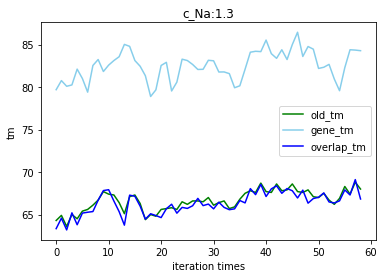

In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# print(data['old_tm'], data['gene_tm'], data['overlap_tm'])
x_axix = [i for i in range(len(data['old_tm']))]
plt.title('c_Na:{0}'.format(input_info['Na']))
plt.plot(x_axix, data['old_tm'], color='green', label='old_tm')
plt.plot(x_axix, data['gene_tm'],  color='skyblue', label='gene_tm')
plt.plot(x_axix, data['overlap_tm'], color='blue', label='overlap_tm')
# plt.plot(x_axix, (data['overlap_tm'] - data['old_tm']), color='red', label='old-new')

plt.legend() # 显示图例

plt.xlabel('iteration times')
plt.ylabel('tm')
plt.show()

In [11]:
print((data['overlap_tm'] - data['old_tm']))

0     6.05
1     6.45
2     6.26
3     6.62
4     6.43
5     6.60
6     6.51
7     6.16
8     6.63
9     6.38
10    6.12
11    6.40
12    6.18
13    7.06
14    6.14
15    6.38
16    6.05
17    6.23
18    6.54
19    5.87
20    6.35
21    6.39
22    5.97
23    6.34
24    6.33
25    5.93
26    6.33
27    6.16
28    6.61
29    6.94
30    6.23
31    6.72
32    6.27
33    6.40
34    6.44
35    6.49
36    6.20
dtype: float64


1446

In [5]:
index = [1,4,6,8,9]
index = index[::-1]
print(index)
index = [10 - i for i in index]
print(index)


[9, 8, 6, 4, 1]
[1, 2, 4, 6, 9]
